# Validation Generation

This notebook can be used to generate the necessary data to compare the 6S and Mitsuba ocean reflectance models.

In [15]:
# Load modules
import numpy as np
from Py6S import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import drjit as dr
import mitsuba as mi


In [16]:
# Set Mitsuba variant
mi.set_variant('llvm_ad_rgb_double')

In [17]:
def sph_to_eucl(theta, phi):
    '''
    Helper function to convert spherical coordinates to Euclidean coordinates
    '''
    st, ct = dr.sincos(theta)
    sp, cp = dr.sincos(phi)
    return mi.Vector3f(cp * st, sp * st, ct)

In [18]:
# Parameters
solar_zenith = 45
solar_azimuth = 0

wind_speed = 25
wind_direction = 0

wavelength = 0.55

pigmentation = 0.3
chlorinity = 19
salinity = 34.3

resolution = 15

## 6S Validation

This section of the notebook is used to generate the data from the 6S model. It requires Py6S to be installed (make sure you install the latest version and adapt the sixs.py file to allow it to run other versions than 6Sv1.1!)

In [19]:
# Initialize the outgoing azimuths/zeniths at which to evaluate the BRDF
sixs_azimuths_o = np.linspace(0, 360, 2 * resolution)
sixs_zeniths_o = np.linspace(1, 89, resolution)

In [20]:
def compute_sixs_brdf():
    '''
    For a given specification, compute the sixs BRDF
    '''
    foam_result = np.zeros((len(sixs_azimuths_o), len(sixs_zeniths_o)))
    glint_result = np.zeros((len(sixs_azimuths_o), len(sixs_zeniths_o)))
    water_result = np.zeros((len(sixs_azimuths_o), len(sixs_zeniths_o)))
    total_result = np.zeros((len(sixs_azimuths_o), len(sixs_zeniths_o)))

    print(f'Shape of results: {foam_result.shape}')

    progress = tqdm(total=len(sixs_azimuths_o) * len(sixs_zeniths_o))

    azimuth_idx = 0
    for azimuth_out in sixs_azimuths_o:
        zenith_idx = 0
        for zenith_out in sixs_zeniths_o:
            s = SixS()
            s.wavelength = Wavelength(wavelength)
            s.atmos_profile = AtmosProfile.PredefinedType(AtmosProfile.NoGaseousAbsorption)
            s.aero_profile = AeroProfile.PredefinedType(AeroProfile.NoAerosols)
            s.ground_reflectance = GroundReflectance.HomogeneousOcean(wind_speed, wind_direction, salinity, pigmentation)

            # Set view parameters
            s.geometry = Geometry.User()
            s.geometry.solar_a = solar_azimuth
            s.geometry.solar_z = solar_zenith
            s.geometry.view_a = azimuth_out
            s.geometry.view_z = zenith_out

            # Run the simulation
            s.run()
            foam = s.outputs.values['water_component_foam']
            glint = s.outputs.values['water_component_glint']
            water = s.outputs.values['water_component_water']
            total = foam + glint + water

            # Save the results
            foam_result[azimuth_idx, zenith_idx] = foam
            glint_result[azimuth_idx, zenith_idx] = glint
            water_result[azimuth_idx, zenith_idx] = water
            total_result[azimuth_idx, zenith_idx] = total * np.cos(np.deg2rad(zenith_out))

            # Update the progress bar
            progress.update(1)

            zenith_idx += 1
        azimuth_idx += 1

    return foam_result.T, glint_result.T, water_result.T, total_result.T


In [21]:
# Generate the 6S samples, depending on the resolution, THIS MAY TAKE A LONG TIME
foam, glint, water, total = compute_sixs_brdf()

Shape of results: (10, 5)


100%|██████████| 50/50 [00:10<00:00,  4.72it/s]


In [22]:
# Statistics
print(f'Foam Statistics')
print(f'    Foam min: {np.min(foam)}')
print(f'    Foam max: {np.max(foam)}')
print(f'    Foam mean: {np.mean(foam)}')

print(f'Glint Statistics')
print(f'    Glint min: {np.min(glint)}')
print(f'    Glint max: {np.max(glint)}')
print(f'    Glint mean: {np.mean(glint)}')

print(f'Water Statistics')
print(f'    Water min: {np.min(water)}')
print(f'    Water max: {np.max(water)}')
print(f'    Water mean: {np.mean(water)}')

Foam Statistics
    Foam min: 0.05407
    Foam max: 0.05407
    Foam mean: 0.05406999999999999
Glint Statistics
    Glint min: 0.0
    Glint max: 0.89393
    Glint mean: 0.04983320000000001
Water Statistics
    Water min: 0.00653
    Water max: 0.00705
    Water mean: 0.006764


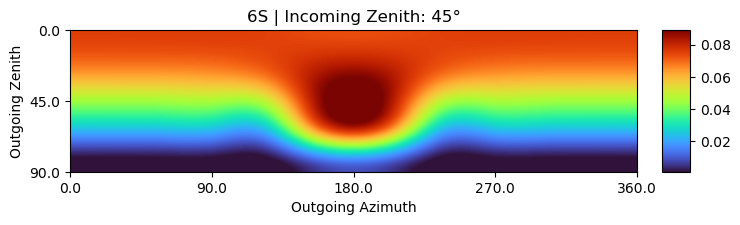

In [23]:
# Plot values for spherical coordinates
fig, ax = plt.subplots(figsize=(8, 4))
visual_set = [foam, glint, water, total]
channel = 3
im = ax.imshow(visual_set[channel], interpolation='spline36', extent=[0, 2 * np.pi, np.pi / 2, 0], cmap='turbo')
#im = ax.imshow(visual_set[channel], interpolation='None', cmap='turbo')

# Name the axes
plt.xlabel("Outgoing Azimuth")
plt.ylabel("Outgoing Zenith")

# Add the title
degrees = np.degrees(solar_zenith)

# Round to 2 decimal places
degrees = round(degrees, 2)

# Add Title
ax.set_title(f'6S | Incoming Zenith: {solar_zenith}°')

# Create x_axis tick labels in degrees
x_ticks = np.linspace(0, 2 * np.pi, 5)
x_labels = np.degrees(x_ticks)
x_labels = [round(label, 2) for label in x_labels]
plt.xticks(x_ticks, x_labels)

# Create y_axis tick labels in degrees
y_ticks = np.linspace(0, np.pi / 2, 3)
y_labels = np.degrees(y_ticks)
y_labels = [round(label, 2) for label in y_labels]
plt.yticks(y_ticks, y_labels)

# Add color bar with same height as the plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.25)
plt.colorbar(im, cax=cax)
plt.show()

In [24]:
# Dump the values in one tensor
sixs_brdf = np.stack([foam, glint, water, total], axis=2)

# Save the tensor file
np.save(f'../brdf/data/6S_brdf_{solar_zenith}_{wind_speed}_{wavelength}.npy', sixs_brdf)

## Mitsuba Implementation

This section of the notebook generates samples from the oceanic Mitsuba BRDF plugin with the exact same parameters as for 6S.

In [25]:
# Create a dummy surface interaction to use for the evaluation of the BSDF
si = dr.zeros(mi.SurfaceInteraction3f)

# Specify an incident direction with X degrees
si.wi = sph_to_eucl(dr.deg2rad(solar_zenith), dr.deg2rad(solar_azimuth))

# Set the surface normal to point upwards
si.n = mi.Vector3f(0, 0, 1)

# Create grid in spherical coordinates and map it into a sphere
zeniths_o, azimuths_o = dr.meshgrid(
    dr.linspace(mi.Float, np.deg2rad(1), np.deg2rad(89), resolution),
    dr.linspace(mi.Float, 0, 2 * dr.pi, 2 * resolution)
)

print(f'Evaluations: {len(zeniths_o) * len(azimuths_o)}')

wo = sph_to_eucl(zeniths_o, azimuths_o)

Evaluations: 2500


In [26]:
# Load and evaluate the BRDF
bsdf = mi.load_dict({
        'type': 'oceanic_legacy',
        'component': 0,
        'wavelength': wavelength,
        'wind_speed': wind_speed,
        'wind_direction': wind_direction,
        'chlorinity': chlorinity,
        'pigmentation': pigmentation,
        'shininess': 50,
    })
brdf = bsdf.eval(mi.BSDFContext(), si, wo)
brdf = np.array(brdf)
brdf = brdf[:,0]
brdf = brdf.reshape(2 * resolution, resolution).T

print(f'BRDF Shape: {brdf.shape}')

BRDF Shape: (5, 10)


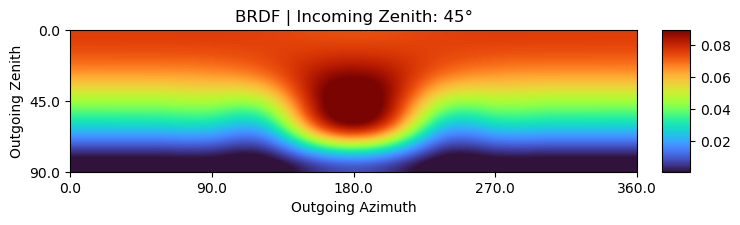

In [27]:
# Plot values for spherical coordinates
fig, ax = plt.subplots(figsize=(8, 4))
im = ax.imshow(brdf, interpolation='spline36', extent=[0, 2 * np.pi, np.pi / 2, 0], cmap='turbo')

# Name the axes
plt.xlabel("Outgoing Azimuth")
plt.ylabel("Outgoing Zenith")

# Add the title
degrees = np.degrees(solar_zenith)

# Round to 2 decimal places
degrees = round(degrees, 2)

# Create x_axis tick labels in degrees
x_ticks = np.linspace(0, 2 * np.pi, 5)
x_labels = np.degrees(x_ticks)
x_labels = [round(label, 2) for label in x_labels]
plt.xticks(x_ticks, x_labels)

# Create y_axis tick labels in degrees
y_ticks = np.linspace(0, np.pi / 2, 3)
y_labels = np.degrees(y_ticks)
y_labels = [round(label, 2) for label in y_labels]
plt.yticks(y_ticks, y_labels)

# Add Title
ax.set_title(f'BRDF | Incoming Zenith: {solar_zenith}°')

# Add color bar with same height as the plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.25)
plt.colorbar(im, cax=cax)
plt.show()

In [29]:
# Dump the values in one tensor
mitsuba_brdf = np.stack(brdf)

# Save the tensor file
np.save(f'../brdf/data/mitsuba_brdf_{solar_zenith}_{wind_speed}_{wavelength}.npy', mitsuba_brdf)